In [3]:
import uuid
from datetime import datetime
from typing import Callable
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import tqdm


class DataStoreException(Exception):
    pass


class DataStore:
    def __init__(self,
                 name=(uuid.uuid4()),
                 cold_start=True,
                 padding=True,
                 differential=300,
                 indicators=list()):
        self._name = name
        self._init_time = datetime.today().strftime('%Y-%m-%d %H:%m:%S')
        self._cold_start = cold_start
        self._indicators = indicators
        self._data = list()
        self._differential = differential
        self._counter = 0
    
    def add_datum(self,datum):
        # check correct object type
        if not isinstance(datum,dict):
            raise DataStoreException('datum must be a python dictionary type object')
            
        # check it has the correct keys
        if 'timestamp' not in datum:
            raise DataStoreException('timestamp key must be provided in datum')
            
        if len(self._data)==0:
            self._data.append(datum)
            self._data_df = pd.DataFrame(datum,index=[self._counter])
            self._counter+=1
        else:
            # check the time differential between data points
            differential = datum['timestamp'] - self._data[-1]['timestamp']
            if differential!=self._differential:
                raise DataStoreException(f'differential of {differential} did not match the stated differential.')
                
            self._data.append(datum)
            
            data_df = pd.DataFrame(datum,index=[self._counter])
            self._data_df = pd.concat([self._data_df,data_df],axis=0)
            
            self.calc_indicators()
            self._counter+=1
            
    def add_data_item(self,data_item,data_item_name):
        last_index = self._data_df.index[-1]
        self._data_df.loc[last_index,data_item_name] = data_item
            
    def calc_indicators(self):
        for indicator in self._indicators:
            if isinstance(indicator, Callable):
                self._data_df.loc[self._counter,indicator.__name__] = indicator(self._data_df)


def mean_l4(x):
    return np.mean(x['close'][-4:])

def trend_l4(x):
    print(len(x))
    if len(x)<=3:
        return 0
    else:
        X = x['close'][-4:]
        Y = x['timestamp'][-4:]
        return np.polyfit(X,Y,1)[0]

import math

def logit(x):
    return 1/(1+math.exp(-0.001*x+0.1))

def model_prob(x):
    #print(x['close'].shape)
    return logit(x['close'][-1:])


if __name__=='__main__':

    model = keras.models.load_model('C:\\Users\\cemly\\Documents\\TimeSeriesForecasting\\StockPrediction\\cnn_model')
    
    def cnn_predict(x):
        if len(x)>21:
            X = x[['close','high','low','open','volume']][-21:].values.reshape(1,21,5)
            return model.predict(X,verbose=0).item(0)
        else:
            return np.nan

    a = DataStore(cold_start=True,indicators=[mean_l4,model_prob,cnn_predict])
    
    start = 400
    for i in tqdm.tqdm(range(1,600)):
        if i==1:
            a.add_datum({'timestamp':i*300,'close':start,'high':start,'low':start,'open':start,'volume':start})
        else:
            start = start+random.randint(-10,10)
            a.add_datum({'timestamp':i*300,'close':start,'high':start,'low':start,'open':start,'volume':start})
            
            if (i%3==0):
                a.add_data_item(i,'test_col')

100%|████████████████████████████████████████████████████████████████████████████████| 599/599 [00:20<00:00, 29.23it/s]


In [4]:
a._data_df

,timestamp,close,high,low,open,volume,mean_l4,model_prob,cnn_predict,test_col
0,300,400,400,400,400,400,NaN,NaN,NaN,NaN
1,600,405,405,405,405,405,402.50,0.575664,NaN,NaN
2,900,410,410,410,410,410,405.00,0.576885,NaN,3.0
3,1200,412,412,412,412,412,406.75,0.577373,NaN,NaN
4,1500,419,419,419,419,419,411.50,0.579081,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
594,178500,242,242,242,242,242,253.50,0.535440,0.913296,NaN
595,178800,240,240,240,240,240,248.00,0.534943,0.913296,NaN
596,179100,233,233,233,233,233,241.50,0.533201,0.913296,597.0
597,179400,234,234,234,234,234,237.25,0.533450,0.913296,NaN


Tasks:
- Datastorer is done
- code bot:
    - pass data to the datastorer
    - inspect the data stored and make decision whether to buy
    - keep track of buy state and decide when to sell? Or just hold for 6 intervals?

In [63]:
model = keras.models.load_model('C:\\Users\\cemly\\Documents\\TimeSeriesForecasting\\StockPrediction\\cnn_model')

def cnn_predict(x):
    if len(x)>21:
        X = x[['volume','close','open','high','low']][-21:]
        X = X/X.iloc[-1]
        print(X)
        X = X.values.reshape(1,21,5)
        return model.predict(X,verbose=0).item(0)
    else:
        return np.nan

class TradingBot:
    def __init__(self,backtest=True):
        self._datastorer = DataStore(cold_start=True,indicators=[cnn_predict])
        self._bought = False
        
    def input_stream(self,datum):
        assert 'timestamp' in datum
        assert isinstance(datum,dict)
        self._datastorer.add_datum(datum)
        self.check_status()
        
    def run_backtest(self,data=None):
        assert isinstance(data,pd.DataFrame)
        rows = len(data)
        for row in range(rows):
            datum = df.iloc[i].to_dict()
            self.input_stream(datum)
    
    def check_status(self):
        if self._bought is True:
            #check whether to sell
            should_sell = self.do_i_sell()
            if should_sell is True:
                self.sell()
        else:
            # check if criteria are met to buy
            should_buy = self.do_i_buy()
            if should_buy is True:
                self.buy()
    
    def buy(self):
        if not self.backtest:
            # use client to purchase and wait for response
            # if purchase successful then add to the datastorer
            pass
        
        # Record that we bought
        self._datastorer.add_data_item(True,'buy')
        self._bought = True
            
    def sell(self):
        if not self.backtest:
            pass
        
        self._datastorer.add_data_item(True,'sell')
    
    def do_i_buy(self):
        return False
    
    def do_i_sell(self):
        return False

In [64]:
# load the test file
file_loc = 'C:\\Users\\cemly\\Documents\\TimeSeriesForecasting\\StockPrediction\\data\\SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(file_loc,parse_dates=['datetime'])
df['timestamp'] = (df['timestamp']/1000).astype(int)
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400,115
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700,37
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000,80
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300,44
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600,21


In [65]:
a = TradingBot()
for i in tqdm.tqdm(df.index.tolist()[:128]):
    a.input_stream(df.loc[i,['timestamp','volume','open','close','high','low']].to_dict())

 17%|█████████████▊                                                                  | 22/128 [00:00<00:00, 196.96it/s]

      volume     close      open      high       low
1   0.409300  0.997321  0.997613  0.997425  0.997529
2   2.248389  0.998137  0.997906  0.998221  0.997823
3   0.401243  0.997509  0.998367  0.998158  0.997718
4   0.238720  0.998116  0.997969  0.998116  0.997906
5   0.108656  0.997990  0.998367  0.998179  0.998199
6   3.726750  0.998242  0.998304  0.998242  0.998137
7   0.198665  0.997990  0.998430  0.998221  0.998199
8   1.424494  0.998074  0.998241  0.998074  0.998241
9   0.213168  0.998053  0.998283  0.998074  0.998220
10  0.866022  0.998765  0.998639  0.998786  0.998639
11  1.301565  0.999016  0.998911  0.999016  0.998807
12  0.355663  0.998849  0.999204  0.999016  0.999058
13  0.175875  0.998911  0.999016  0.998911  0.999016
14  2.721685  0.999330  0.999183  0.999330  0.999183
15  0.537753  0.999267  0.999539  0.999456  0.999477
16  0.891805  0.999581  0.999560  0.999728  0.999560
17  0.752762  0.999749  0.999895  0.999770  0.999895
18  0.363490  0.999749  1.000167  0.999958  0.

       volume     close      open      high       low
12   0.881346  0.998368  0.998243  0.998264  0.998368
13   0.435824  0.998431  0.998055  0.998159  0.998326
14   6.744438  0.998849  0.998222  0.998578  0.998494
15   1.332573  0.998786  0.998578  0.998703  0.998786
16   2.209926  0.999100  0.998599  0.998975  0.998870
17   1.865374  0.999268  0.998933  0.999017  0.999205
18   0.900742  0.999268  0.999205  0.999205  0.999268
19   0.403309  0.999414  0.999059  0.999142  0.999330
20   0.684541  0.999289  0.999101  0.999163  0.999289
21   2.478038  0.999519  0.999038  0.999247  0.999310
22   0.536224  0.999330  0.999121  0.999121  0.999330
23   2.349686  0.999602  0.999268  0.999331  0.999540
24   2.650314  0.999895  0.999331  0.999686  0.999602
25  22.399886  1.000105  0.999707  0.999833  0.999958
26   1.650884  1.000042  0.999854  0.999916  1.000042
27   1.412436  1.000042  0.999791  0.999812  1.000042
28   1.567598  1.000230  0.999916  0.999958  1.000146
29   6.693098  0.999874  1.0

 33%|██████████████████████████▌                                                      | 42/128 [00:00<00:01, 44.96it/s]

      volume     close      open      high       low
19  0.150362  0.999644  0.999602  0.999623  0.999602
20  0.255211  0.999519  0.999644  0.999644  0.999561
21  0.923862  0.999749  0.999581  0.999728  0.999581
22  0.199915  0.999561  0.999665  0.999602  0.999602
23  0.876010  0.999833  0.999812  0.999812  0.999812
24  0.988090  1.000126  0.999874  1.000167  0.999874
25  8.351127  1.000335  1.000251  1.000314  1.000230
26  0.615483  1.000272  1.000398  1.000398  1.000314
27  0.526584  1.000272  1.000335  1.000293  1.000314
28  0.584432  1.000460  1.000460  1.000439  1.000419
29  2.495321  1.000105  1.000544  1.000502  1.000042
30  0.762442  1.000335  1.000251  1.000335  1.000251
31  0.364100  1.000439  1.000377  1.000419  1.000314
32  0.372820  1.000230  1.000544  1.000481  1.000272
33  0.357933  1.000293  1.000272  1.000272  1.000188
34  0.266908  1.000356  1.000335  1.000335  1.000272
35  0.151000  1.000335  1.000377  1.000314  1.000377
36  3.582943  1.000167  1.000419  1.000439  1.

 41%|████████████████████████████████▉                                                | 52/128 [00:01<00:02, 37.96it/s]

      volume     close      open      high       low
32  0.019248  1.001215  1.001508  1.001445  1.001320
33  0.018479  1.001278  1.001236  1.001236  1.001236
34  0.013780  1.001341  1.001299  1.001299  1.001320
35  0.007796  1.001320  1.001341  1.001278  1.001425
36  0.184979  1.001152  1.001383  1.001403  1.001194
37  0.056503  1.000880  1.001131  1.001068  1.000901
38  0.040077  1.001006  1.000796  1.000964  1.000859
39  0.051628  1.000985  1.000964  1.000964  1.001048
40  0.085237  1.000775  1.001006  1.001005  1.000880
41  0.125600  1.000775  1.000733  1.001005  1.000796
42  0.236882  1.000649  1.000817  1.000754  1.000545
43  0.119704  1.000607  1.000608  1.000566  1.000545
44  0.143706  1.000503  1.000628  1.000691  1.000587
45  0.230557  1.000314  1.000503  1.000440  1.000021
46  0.275015  1.000377  1.000377  1.000503  1.000419
47  0.168235  1.000084  1.000335  1.000314  1.000189
48  0.554543  1.000251  1.001237  1.001257  1.000063
49  0.098380  1.000147  1.000251  1.000230  1.

 46%|█████████████████████████████████████▎                                           | 59/128 [00:01<00:01, 34.73it/s]

      volume     close      open      high       low
38  0.212716  1.001236  1.000859  1.000964  1.001111
39  0.274025  1.001215  1.001027  1.000964  1.001299
40  0.452416  1.001006  1.001068  1.001005  1.001132
41  0.666647  1.001006  1.000796  1.001005  1.001048
42  1.257299  1.000880  1.000880  1.000754  1.000796
43  0.635352  1.000838  1.000670  1.000566  1.000796
44  0.762748  1.000733  1.000691  1.000691  1.000838
45  1.223731  1.000545  1.000566  1.000440  1.000272
46  1.459700  1.000608  1.000440  1.000503  1.000671
47  0.892942  1.000314  1.000398  1.000314  1.000440
48  2.943353  1.000482  1.001300  1.001257  1.000314
49  0.522175  1.000377  1.000314  1.000230  1.000314
50  0.865552  1.000335  1.000314  1.000189  0.999246
51  0.839501  1.000189  1.000168  1.000147  1.000210
52  5.307710  1.000230  1.000063  1.000000  1.000251
53  5.052217  1.000398  1.000084  1.000168  1.000251
54  1.620666  1.000000  1.000251  1.000230  1.000000
55  2.666064  1.000021  0.999937  0.999895  1.

 51%|█████████████████████████████████████████▏                                       | 65/128 [00:01<00:01, 32.41it/s]

      volume     close      open      high       low
44  0.804129  1.001993  1.001825  1.001930  1.002077
45  1.290120  1.001804  1.001699  1.001678  1.001511
46  1.538892  1.001867  1.001573  1.001741  1.001909
47  0.941386  1.001573  1.001531  1.001552  1.001679
48  3.103035  1.001741  1.002434  1.002496  1.001553
49  0.550504  1.001636  1.001447  1.001468  1.001553
50  0.912509  1.001594  1.001447  1.001426  1.000483
51  0.885045  1.001448  1.001300  1.001384  1.001448
52  5.595662  1.001490  1.001195  1.001237  1.001490
53  5.326309  1.001657  1.001216  1.001405  1.001490
54  1.708589  1.001259  1.001384  1.001468  1.001238
55  2.810703  1.001280  1.001070  1.001133  1.001364
56  2.209204  1.001112  1.000944  1.000986  1.001007
57  0.989002  1.001238  1.000839  1.001091  1.001217
58  1.054252  1.001259  1.001133  1.001237  1.001238
59  6.668530  0.999790  1.001007  1.000986  0.999832
60  4.794790  0.999580  0.999455  0.999685  0.999350
61  2.026849  0.999895  0.999350  0.999602  0.

 58%|██████████████████████████████████████████████▊                                  | 74/128 [00:02<00:01, 30.08it/s]

      volume     close      open      high       low
50  0.006205  1.005031  1.005433  1.004185  1.006310
51  0.006018  1.004884  1.005285  1.004143  1.007281
52  0.038049  1.004926  1.005180  1.003996  1.007323
53  0.036218  1.005094  1.005201  1.004164  1.007323
54  0.011618  1.004694  1.005370  1.004227  1.007070
55  0.019112  1.004715  1.005054  1.003891  1.007196
56  0.015022  1.004547  1.004927  1.003744  1.006838
57  0.006725  1.004673  1.004822  1.003849  1.007049
58  0.007169  1.004694  1.005117  1.003996  1.007070
59  0.045345  1.003221  1.004991  1.003744  1.005656
60  0.032604  1.003010  1.003432  1.002440  1.005170
61  0.013782  1.003326  1.003327  1.002355  1.005023
62  0.011625  1.003558  1.003664  1.002587  1.005592
63  0.013653  1.003747  1.003727  1.002860  1.005614
64  0.006800  1.003431  1.003980  1.002755  1.005825
65  0.050449  1.002758  1.003727  1.002608  1.005107
66  0.817891  1.004294  1.002948  1.003533  1.005002
67  0.543050  1.004758  1.004590  1.004690  1.

 61%|█████████████████████████████████████████████████▎                               | 78/128 [00:02<00:01, 29.53it/s]

      volume     close      open      high       low
56  0.056335  1.002016  1.002247  1.002163  1.003196
57  0.025220  1.002142  1.002142  1.002268  1.003406
58  0.026883  1.002163  1.002436  1.002415  1.003427
59  0.170048  1.000693  1.002310  1.002163  1.002019
60  0.122267  1.000483  1.000756  1.000861  1.001535
61  0.051685  1.000798  1.000651  1.000777  1.001388
62  0.043596  1.001029  1.000987  1.001008  1.001956
63  0.051202  1.001218  1.001050  1.001281  1.001977
64  0.025500  1.000903  1.001302  1.001176  1.002187
65  0.189188  1.000231  1.001050  1.001029  1.001472
66  3.067187  1.001764  1.000273  1.001953  1.001367
67  2.036503  1.002226  1.001911  1.003108  1.002797
68  1.170851  1.001974  1.002310  1.002518  1.003033
69  2.956688  0.997186  1.002121  1.002205  0.997876
70  3.750120  0.997480  0.997333  0.998425  0.996383
71  3.146859  0.997263  0.997606  0.998551  0.997771
72  2.162856  0.997984  0.997417  0.998929  0.998318
73  1.406141  0.997879  0.998131  0.998439  0.

 67%|██████████████████████████████████████████████████████▍                          | 86/128 [00:02<00:01, 28.69it/s]

      volume     close      open      high       low
62  0.056299  1.001281  1.000714  1.000798  1.001135
63  0.066122  1.001470  1.000777  1.001071  1.001156
64  0.032931  1.001155  1.001029  1.000966  1.001366
65  0.244317  1.000483  1.000777  1.000819  1.000651
66  3.960955  1.002016  1.000000  1.001742  1.000546
67  2.629933  1.002478  1.001638  1.002897  1.001975
68  1.512033  1.002226  1.002037  1.002307  1.002212
69  3.818256  0.997438  1.001848  1.001994  0.997059
70  4.842892  0.997732  0.997061  0.998216  0.995567
71  4.063842  0.997514  0.997334  0.998342  0.996954
72  2.793105  0.998236  0.997145  0.998719  0.997500
73  1.815885  0.998131  0.997858  0.998229  0.997731
74  1.812166  0.999916  0.997733  0.999685  0.998445
75  1.671912  1.000147  0.999538  1.000168  0.999685
76  1.291396  1.000252  0.999727  0.999790  0.999181
77  1.281068  1.001344  0.999811  1.000882  1.000252
78  1.691250  0.999790  1.000924  1.000924  0.999265
79  1.503194  0.999727  0.999370  0.999685  0.

 72%|██████████████████████████████████████████████████████████▏                      | 92/128 [00:02<00:01, 27.99it/s]

      volume     close      open      high       low
68  1.615067  1.003470  1.004272  1.003726  1.004131
69  4.078443  0.998675  1.004082  1.003413  0.998969
70  5.172899  0.998970  0.999285  0.999629  0.997474
71  4.340763  0.998752  0.999558  0.999755  0.998863
72  2.983435  0.999474  0.999369  1.000133  0.999411
73  1.939624  0.999369  1.000084  0.999642  0.999642
74  1.935652  1.001157  0.999958  1.001100  1.000358
75  1.785840  1.001388  1.001768  1.001584  1.001600
76  1.379396  1.001493  1.001957  1.001205  1.001095
77  1.368363  1.002587  1.002041  1.002298  1.002168
78  1.806496  1.001030  1.003156  1.002341  1.001179
79  1.605625  1.000967  1.001599  1.001100  1.001579
80  0.840930  1.000799  1.001578  1.001437  1.001516
81  2.933003  1.001597  1.001377  1.001479  1.001452
82  1.068143  1.001241  1.002230  1.001415  1.001916
83  0.828724  1.001367  1.001831  1.001247  1.001768
84  0.804826  1.000925  1.001936  1.001226  1.001558
85  0.990519  1.000252  1.001473  1.001100  1.

 77%|██████████████████████████████████████████████████████████████                   | 98/128 [00:02<00:01, 27.55it/s]

      volume     close      open      high       low
74  1.170605  1.001475  0.999411  1.001262  1.000316
75  1.080005  1.001706  1.001220  1.001745  1.001558
76  0.834203  1.001811  1.001409  1.001367  1.001052
77  0.827531  1.002905  1.001493  1.002460  1.002126
78  1.092497  1.001348  1.002608  1.002502  1.001137
79  0.971018  1.001285  1.001052  1.001262  1.001537
80  0.508561  1.001117  1.001030  1.001598  1.001473
81  1.773763  1.001916  1.000830  1.001640  1.001410
82  0.645970  1.001559  1.001682  1.001577  1.001873
83  0.501179  1.001685  1.001283  1.001409  1.001726
84  0.486726  1.001243  1.001388  1.001388  1.001516
85  0.599026  1.000570  1.000925  1.001262  1.000926
86  1.076322  0.999813  1.000273  1.000189  1.000253
87  1.054307  0.999729  0.999558  0.999727  0.999958
88  0.604760  1.000318  0.999453  1.000161  0.999958
89  0.614215  1.000339  1.000000  1.000021  1.000432
90  0.476195  0.999644  1.000084  0.999937  1.000147
91  1.274778  0.998277  0.999348  0.999327  0.

 81%|█████████████████████████████████████████████████████████████████               | 104/128 [00:03<00:00, 26.64it/s]

       volume     close      open      high       low
80   0.799552  0.999958  1.000841  1.000746  1.000378
81   2.788687  1.000756  1.000640  1.000788  1.000315
82   1.015586  1.000399  1.001493  1.000725  1.000778
83   0.787947  1.000525  1.001093  1.000557  1.000631
84   0.765225  1.000084  1.001199  1.000536  1.000421
85   0.941781  0.999412  1.000736  1.000410  0.999832
86   1.692179  0.998655  1.000084  0.999338  0.999159
87   1.657568  0.998571  0.999369  0.998876  0.998865
88   0.950796  0.999160  0.999264  0.999310  0.998865
89   0.965660  0.999181  0.999811  0.999170  0.999338
90   0.748667  0.998487  0.999895  0.999086  0.999054
91   2.004190  0.997121  0.999159  0.998477  0.997603
92   1.120890  0.998781  0.997897  0.998666  0.997855
93   1.041266  0.999096  0.999453  0.999674  0.999159
94   1.572187  0.998842  0.999811  0.999149  0.998907
95   0.608666  0.998823  0.999579  0.999044  0.999233
96   0.635421  0.998886  0.999432  0.998855  0.998823
97   0.599489  0.999181  0.9

 86%|████████████████████████████████████████████████████████████████████▊           | 110/128 [00:03<00:00, 26.42it/s]

       volume     close      open      high       low
87   3.106267  0.999243  0.999348  0.999495  0.998985
88   1.781782  0.999832  0.999243  0.999930  0.998985
89   1.809638  0.999853  0.999790  0.999790  0.999458
90   1.402996  0.999159  0.999874  0.999706  0.999174
91   3.755833  0.997792  0.999138  0.999096  0.997723
92   2.100537  0.999453  0.997876  0.999285  0.997975
93   1.951324  0.999769  0.999432  1.000294  0.999279
94   2.946264  0.999514  0.999790  0.999769  0.999027
95   1.140634  0.999495  0.999558  0.999664  0.999353
96   1.190774  0.999558  0.999411  0.999474  0.998942
97   1.123437  0.999853  0.999516  0.999727  0.999099
98   1.440936  0.999958  0.999832  0.999853  0.999321
99   1.801302  1.000021  0.999937  0.999895  0.999742
100  1.873991  1.000673  0.999979  1.000620  1.000120
101  1.177200  1.000694  1.000673  1.000526  1.000499
102  0.760207  1.000416  1.000694  1.000526  1.000414
103  0.812742  1.000210  1.000421  1.000378  1.000162
104  0.877048  1.000105  1.0

 93%|██████████████████████████████████████████████████████████████████████████▍     | 119/128 [00:03<00:00, 26.72it/s]

       volume     close      open      high       low
93   2.153584  0.998802  0.998523  0.999275  0.998298
94   3.251652  0.998548  0.998880  0.998750  0.998046
95   1.258864  0.998529  0.998649  0.998645  0.998372
96   1.314201  0.998592  0.998502  0.998456  0.997962
97   1.239884  0.998886  0.998607  0.998708  0.998119
98   1.590293  0.998992  0.998922  0.998834  0.998340
99   1.988011  0.999055  0.999027  0.998876  0.998761
100  2.068235  0.999706  0.999069  0.999601  0.999139
101  1.299220  0.999727  0.999762  0.999506  0.999517
102  0.839005  0.999449  0.999783  0.999506  0.999433
103  0.896985  0.999244  0.999510  0.999359  0.999181
104  0.967956  0.999139  0.999321  0.999086  0.998908
105  1.311719  0.999433  0.999216  0.999254  0.999286
106  1.063977  0.998996  0.999499  0.999496  0.999055
107  1.103653  0.999034  0.999090  0.998981  0.999019
108  3.551463  0.999118  0.999090  0.998939  0.998718
109  1.064601  0.998739  0.999195  0.998939  0.998782
110  3.330894  0.999664  0.9

 95%|████████████████████████████████████████████████████████████████████████████▎   | 122/128 [00:03<00:00, 26.76it/s]

       volume     close      open      high       low
99   0.675035  0.997630  0.997713  0.997651  0.997566
100  0.702275  0.998280  0.997755  0.998374  0.997944
101  0.441154  0.998301  0.998448  0.998280  0.998321
102  0.284886  0.998024  0.998469  0.998280  0.998237
103  0.304574  0.997819  0.998196  0.998133  0.997986
104  0.328672  0.997714  0.998007  0.997861  0.997713
105  0.445398  0.998007  0.997902  0.998028  0.998091
106  0.361276  0.997571  0.998185  0.998270  0.997860
107  0.374748  0.997609  0.997776  0.997756  0.997824
108  1.205909  0.997693  0.997776  0.997714  0.997524
109  0.361488  0.997315  0.997881  0.997714  0.997587
110  1.131014  0.998238  0.997503  0.998658  0.997409
111  0.426977  0.998406  0.998448  0.998595  0.998468
112  0.502096  0.998490  0.998594  0.998721  0.998762
113  0.339553  0.998574  0.998685  0.998773  0.998804
114  0.425246  0.998364  0.998794  0.998804  0.998531
115  0.696744  0.998406  0.998531  0.998532  0.998647
116  0.898771  0.999245  0.9

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 31.77it/s]

       volume     close      open      high       low
105  1.077496  0.997631  0.997756  0.997673  0.997840
106  0.873991  0.997195  0.998039  0.997914  0.997609
107  0.906582  0.997232  0.997630  0.997400  0.997573
108  2.917306  0.997316  0.997630  0.997358  0.997274
109  0.874504  0.996939  0.997735  0.997358  0.997337
110  2.736123  0.997861  0.997357  0.998302  0.997158
111  1.032934  0.998029  0.998301  0.998239  0.998218
112  1.214658  0.998113  0.998448  0.998365  0.998511
113  0.821438  0.998197  0.998539  0.998417  0.998553
114  1.028744  0.997987  0.998647  0.998448  0.998281
115  1.685546  0.998029  0.998385  0.998176  0.998396
116  2.174286  0.998868  0.998427  0.998889  0.998386
117  1.409167  0.998889  0.999287  0.998889  0.998952
118  1.240383  0.999455  0.999287  0.999413  0.999351
119  2.419176  0.999623  0.999853  0.999644  0.999749
120  1.445152  0.999539  1.000000  0.999811  0.999833
121  2.131829  1.000126  0.999937  1.000294  0.999812
122  1.624709  0.999916  1.0

In [6]:
# a = TradingBot()
# start = 400
# for i in tqdm.tqdm(range(1,600)):
#     if i==1:
#         a.input_stream({'timestamp':i*300,'close':start,'high':start,'low':start,'open':start,'volume':start})
#     else:
#         start = start+random.randint(-10,10)
#         a.input_stream({'timestamp':i*300,'close':start,'high':start,'low':start,'open':start,'volume':start})

100%|████████████████████████████████████████████████████████████████████████████████| 599/599 [00:19<00:00, 29.95it/s]


<AxesSubplot:>

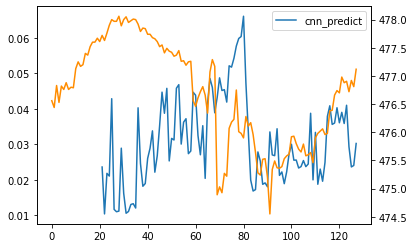

In [72]:
axes = a._datastorer._data_df[['cnn_predict']].plot()
axes2 = axes.twinx()
a._datastorer._data_df['close'].plot(ax=axes2,c='darkorange')

<AxesSubplot:>

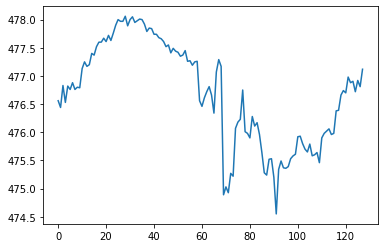

In [69]:
a._datastorer._data_df['close'].plot()

In [59]:
x = a._datastorer._data_df[-21:]
x/x.iloc[-1]

,timestamp,volume,open,close,high,low,cnn_predict
107,0.999996,0.511607,0.997462,0.996816,0.997026,0.997489,1.049242
108,0.999997,1.646310,0.997462,0.996900,0.996984,0.997189,0.964940
109,0.999997,0.493505,0.997567,0.996523,0.996984,0.997252,1.063857
110,0.999997,1.544064,0.997190,0.997445,0.997927,0.997074,0.971084
111,0.999997,0.582911,0.998133,0.997613,0.997864,0.998133,1.057004
112,0.999997,0.685463,0.998280,0.997697,0.997990,0.998427,1.019708
113,0.999997,0.463558,0.998371,0.997781,0.998042,0.998469,1.075793
114,0.999998,0.580547,0.998479,0.997571,0.998074,0.998196,1.020756
115,0.999998,0.951196,0.998217,0.997613,0.997801,0.998311,0.985813
116,0.999998,1.227005,0.998259,0.998451,0.998514,0.998301,0.972136


In [7]:
a._datastorer._data_df['cnn_predict']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
594    0.013165
595    0.011354
596    0.012499
597    0.011661
598    0.010682
Name: cnn_predict, Length: 599, dtype: float64

In [52]:
model.predict(a._data_df[['close','high','low','open','volume']][-21:].values.reshape(1,21,5),verbose=0).item(0)

0.9132961630821228

<AxesSubplot:>

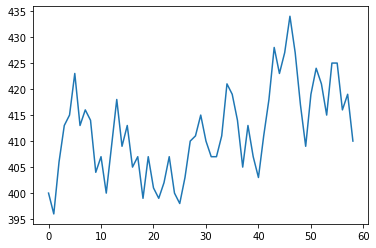

In [13]:
a._data_df['close'].plot()

In [184]:
a._data_df['close'][-1:][0]

400

In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import math
from matplotlib import pyplot as plt
import sys

import warnings
warnings.simplefilter('ignore', np.RankWarning)

'''
dataset which accepts data points through time. Has two modes:
- irregular:
    - stores random datapoints through time.
    - doesn't perform any checks, just stores the data in it's raw form
- regular:
    - stores the data through time
    - checks its regular, checks for any missing datapoints
    - interpolates missing data points, if missing
    - calculates indicators like RSI, gradients of varying order, etc....
    - can splice in an irregular dataset into a regular one?
'''

class DataStoreException(Exception):
    pass


class DataStore:
    ''' Class which iteratively stores data points, calculating statistical indicators as it goes along.'''

    def __init__(self,
                name:str,
                cold_start: bool=True,
                is_regular: bool=True, 
                indicators: list=['rolling_mean_30','rolling_median_30','calc_trend_30','calc_acceleration_30']):

        self._name = name
        self.init_time = time.time()
        self._unique_id = f'{name}_{self.init_time}'

        self._data = pd.DataFrame()
        self.is_regular = is_regular

        # Indicators is a list contain all the indicators which will be calculated on the go as each data point is added
        self._indicators = indicators

        #self.mlp = joblib.load('/home/cemlyn/Documents/BinanceBot/app/data/models/mlp_model.bz2')
        self.mlp_covars = list()
    
    def add_datum(self,datum:pd.DataFrame):
        ''' Add new data from the websocket feed to here - Note that data points are only added when the kline is closed. '''
        # Append new data points
        self._data = pd.concat([self._data,datum],axis=0)

        if not self.check_is_regular():
            pass
        
        self.calc_indicators(*self._indicators)


    def insert_datum(self,datum:pd.DataFrame):
        self._data = self._data.combine_first(datum)


    def check_is_regular(self):
        ''' Checks the close times series to see if time intervals are regular. '''
        close_times = self._data.reset_index()[['close-time']].copy()

        if len(close_times)<2:
            return True

        close_times.loc[:,'close-time-diff'] = close_times['close-time'].diff()

        if (close_times['close-time-diff'].dropna().nunique())>1:
            return False
        else:
            return True
    

    def calc_indicators(self,*args):
        for arg in args:
            func = getattr(DataStore,arg)
            self.calc_indicator(func)


    def calc_indicator(self,func):
        ''' Calculates values for the indicator. '''
        indicator_name = func.__name__
        indicator_value = func(self._data['close-price'])

        if indicator_name not in self._data:
            self._data.loc[:,indicator_name] = indicator_value
        else:
            indicator_index_value = self._data.columns.tolist().index(indicator_name)
            self._data.iloc[-1,indicator_index_value] = indicator_value



    @staticmethod
    def rolling_mean_30(series):
        return np.mean(series.iloc[-30:])

    @staticmethod
    def rolling_median_30(series):
        return np.median(series.iloc[-30:])

    @staticmethod
    def calc_trend_30(series):
        x = series.iloc[-30:].index.astype(float).values
        y = series.iloc[-30:].astype(float).values
        
        if len(series)>3:
            grad = np.polyfit(x,y,1,full=False)[0]
        else:
            grad = np.nan
        return grad

    @staticmethod
    def calc_trend(series):
        x = series.dropna().index.astype(float).values
        y = series.dropna().astype(float).values
        if len(y)>3:
            grad = np.polyfit(x,y,1,full=False)[0]
        else:
            grad = np.nan
        return grad

    @staticmethod
    def calc_acceleration_30(series):
        first_order = series.iloc[-60:].rolling(30).apply(lambda x: DataStore.calc_trend(x))
        first_order = first_order.iloc[-30:]
        return DataStore.calc_trend(first_order)

# if __name__ == "__main__":
    
#     store = DataStore(name="Test")

#     df = pd.read_csv('bot.csv',index_col=0)

#     for n,row in enumerate(df.iterrows()):
#         store.add_datum(row[1].to_frame().T)

#     store._data.to_csv('cvb.csv')